<a href="https://colab.research.google.com/github/falarion08/Hotel-Recommendation-System/blob/main/Hotel_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Group 6: Hotel Recommendation System
Note: Profile Matrix (decimal numbers)


To do:
* Fix formatting - Ryan
* check and fix data cleaning (for users): Jude & Rachelle
* check and fix data cleaning for hotel dataframe: Pheobe & Ryan
* Perform cosine similarty for a random user(Content-based - Explicit Rating mean-subtraction variation): Kyle



#Introduction

The hospitality industry has taken a deep turn these past few years due to the pandemic. As government restrictions were put into place, guests were not able to stay at hotels and go on vacations for a significant amount of time. However, as the country is slowly going back to the norm, hotels and accommodations are being more open and guests may be able to go on to vacations again. With this in mind, it is important to stay at hotels that meet the criteria of the staying guests. In line with this, guests are becoming more mindful with staying at hotels and accommodations to ensure that where they are staying are up to their standards and meet their needs and criteria. As such, the main objective of this project is to develop a user-friendly recommender system for hotel reviews which enables users to easily look for hotels that match their criteria and check its reviews. This enhances the hotel selection process and provides users with better suggestion that best suit their preferences and needs.

The main beneficiaries of this recommender system are the following:

*   Guests: This recommender system would allow them to easily check for hotel reviews and to easily see which hotels are better suited for their needs. With this, they make more informed decisions when it comes to their hotel accommodations.
*   Hotel Companies: The system would benefit them as they would easily see the reviews for their hotel, and would allow them to create strategies to better improve their hotel in accordance to the reviews and common criteria of guests. In addition, this system may increase their exposure and it would allow hotel management to understand better what consumers look for when it comes to accommodations.
*   Online Travel Agencies and Sites: This system may make online travel agencies and sites more efficient and effective when it comes to recommending hotel accommodations to users.




#Data Collection

In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common import exceptions
from time import sleep
from unidecode import unidecode
from random import randint
import numpy as np

Data was taken from Agoda website and scraped hotel information along with hotel reviews using selenium.

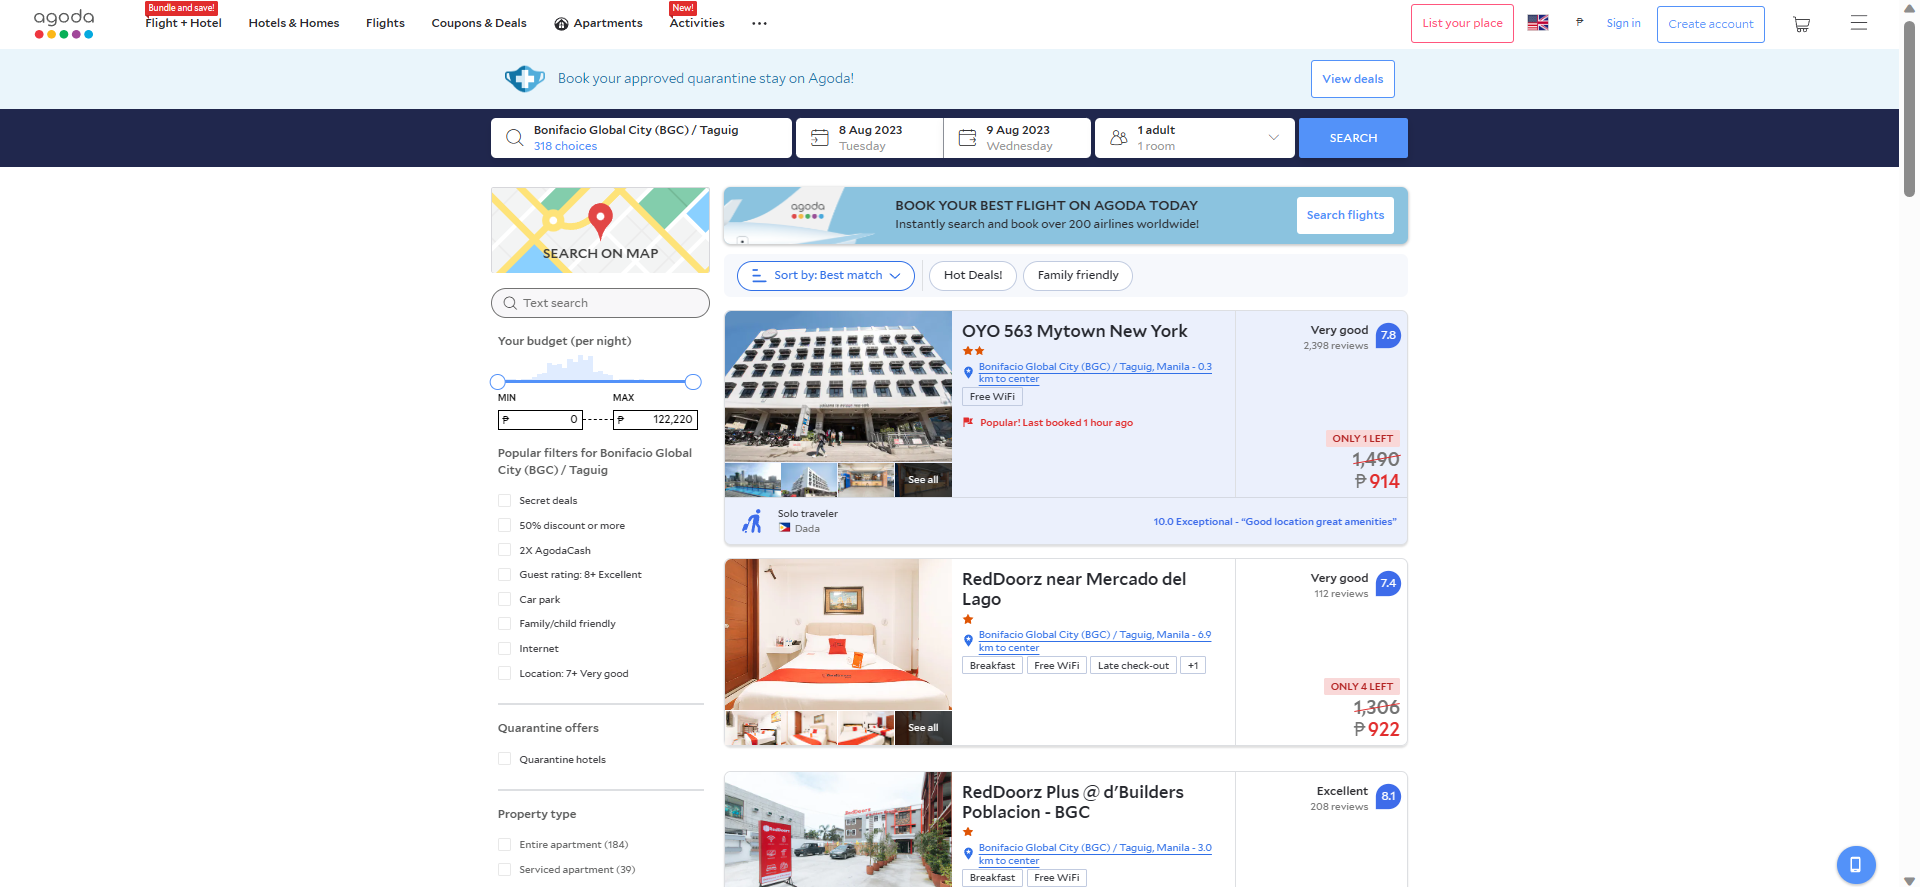

In [ ]:
drive_path = './Driver/chromedriver.exe'
url = 'https://www.agoda.com/search?area=571269&locale=en-us&ckuid=12f8264b-428c-4a49-a16e-f85616b7f9fe&prid=0&gclid=EAIaIQobChMIjcrjz_2ogAMV1V0rCh13BQDxEAAYASAAEgIPIvD_BwE&currency=PHP&correlationId=2ea4f605-5fb9-4fd0-a3db-b0747e9205d6&analyticsSessionId=3118740912916874695&pageTypeId=103&realLanguageId=1&languageId=1&origin=PH&cid=1891467&tag=1b1738b9-a624-86b7-52bb-979616124dd3&userId=12f8264b-428c-4a49-a16e-f85616b7f9fe&whitelabelid=1&loginLvl=0&storefrontId=3&currencyId=18&currencyCode=PHP&htmlLanguage=en-us&cultureInfoName=en-us&machineName=hk-pc-2g-acm-web-user-7fdb9497b6-8jcl6&trafficGroupId=5&sessionId=nzunic5hsy4ds3nsronvws2d&trafficSubGroupId=122&aid=82361&useFullPageLogin=true&cttp=4&isRealUser=true&mode=production&browserFamily=Chrome&checkIn=2023-07-28&checkOut=2023-07-29&rooms=1&adults=1&children=0&priceCur=PHP&los=1&textToSearch=Bonifacio%20Global%20City%20(BGC)%20%2F%20Taguig&travellerType=0&familyMode=off&productType=-1'

# Create a driver object using the latest edition of chrome driver
driver = webdriver.Chrome(drive_path)

# Connect to the url provided
driver.get(url)

In [ ]:
def scrollDown():
  # The function executes a script that scrolls down until the end of the webpage is reached
  lastHeight = driver.execute_script("return document.body.scrollHeight")
  while True:
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      sleep(0.5)
      newHeight = driver.execute_script("return document.body.scrollHeight")
      if newHeight == lastHeight:
          break
      lastHeight = newHeight

def getHotelLinks():
  """
   The function returns a list of url made from the the lists of hotels available,
   and returns a clickable "Next button" object that navigates to the next available lists of hotels
   if there are any
  """
  scrollDown()
  sleep(7)
  links = driver.find_elements(By.XPATH, "//a[@class = 'PropertyCard__Link']")
  sleep(5)

  for i in range(len(links)):
      links[i] = links[i].get_property(name = 'href')

  try:
      next_button = driver.find_element(By.XPATH, "//button[@id = 'paginationNext']")
  except(exceptions.NoSuchElementException):
      next_button = None

  return (next_button, links)

In [ ]:
def getHotelFeaturesDataFrame():
  # Returns a dataframe that contains hotel features
    hotelID = driver.find_element(By.XPATH, "//p[@class ='HeaderCerebrum__Name']").text
    features = driver.find_elements(By.XPATH,"//div[@data-element-name ='facility-highlights-item']")
    sleep(3)
    counter = 0

    for feature in features:
        features[counter] = features[counter].text
        counter = counter + 1

    sub_fac_df = pd.DataFrame(pd.get_dummies(features).sum(axis = 0), index = features).T
    features.insert(0, 'hotel_ID')

    sub_fac_df['hotel_ID'] = hotelID
    sub_fac_df = sub_fac_df[features]

    return sub_fac_df

def getCustomerReviewsDataFrame():
  # Returns a dataframe that contains user review
    usernames = []
    user_rating = []
    date = []

    hotelID = driver.find_element(By.XPATH, "//p[@class ='HeaderCerebrum__Name']").text
    user_info = driver.find_elements(By.XPATH, "//div[@data-info-type='reviewer-name']")
    ratings = driver.find_elements(By.XPATH, "//div[@class = 'Review-comment-leftScore']")
    reviewDate = driver.find_elements(By.XPATH, "//span[@class = 'Review-statusBar-date ']")

    sleep(6)
    for i in range(len(user_info)):
      # Return a unicode for usernames that are not in ASCII format
        usernames.append(unidecode(user_info[i].text.split()[0]).strip())
        user_rating.append(float(ratings[i].text))
        date_format = reviewDate[i].text.split(' ')
        date.append(date_format[1] +' ' + date_format[2][:-1] + ' '+ date_format[3])

    user_df = pd.DataFrame({
    'userID': usernames,
    'Rating':user_rating,
    'hotel_ID': hotelID,
    'review_date': date
    })
    return user_df


Implementation of the webscraping process

In [ ]:
counter = 0

while counter < len(links):
    try:
        driver.get(links[counter])
        sleep(5)
        scrollDown()
        sleep(randint(3,7))
        features_df = pd.concat([features_df,getHotelFeaturesDataFrame()], ignore_index= True)
        users_df = pd.concat([users_df, getCustomerReviewsDataFrame()], ignore_index = True)

        counter = counter + 1

    except:
        print('Exception Occured')
        sleep(30)
        driver.refresh()

In [ ]:
# Convert the obtained dataframe into csv files in order to save the scraped data.
users_df.to_csv('user_ratings.csv', index=False)
features_df.to_csv('hotel_features.csv', index=False)

#Data Preprocessing and Feature Engineering

### Preprocessing and Feature Engineering for User DataFrame

In [40]:
import pandas as pd

file_path = '/content/user_ratings.csv'
users_df = pd.read_csv(file_path)


###Metadata

*   **UserID** - The username of the user that wrote the review.
*  **Rating** - A floating point value that ranges from 0.0 to 10.0
* **review_date** - Month, day, and year of when the review was made
* **hotel_ID** - The name of the hotel the user has made a review on.




In [41]:
users_df

,userID,Rating,review_date,hotel_ID
0,Sandip,10.0,January 31 2023,F1 Hotel Manila
1,Duane,10.0,October 21 2022,F1 Hotel Manila
2,Peter,10.0,August 21 2022,F1 Hotel Manila
3,Ma.,10.0,November 05 2022,F1 Hotel Manila
4,Lyra,10.0,January 09 2023,F1 Hotel Manila
...,...,...,...,...
1081,Ma.cristina,10.0,June 29 2023,Muggle Stay Guest House - Bonifacio Global Cit...
1082,Rochyr,7.0,June 28 2023,Muggle Stay Guest House - Bonifacio Global Cit...
1083,Yen,1.0,June 22 2023,Muggle Stay Guest House - Bonifacio Global Cit...
1084,Teresa,8.0,June 11 2023,Muggle Stay Guest House - Bonifacio Global Cit...


In [42]:
# Assuming users_df is the DataFrame containing the data
user_appearances = users_df['userID'].value_counts()

print(user_appearances)


Maria       19
Michelle    13
Mark         9
David        8
Darren       8
            ..
Andrew       1
Leslei       1
Fahad        1
FRANNIE      1
Teresa       1
Name: userID, Length: 785, dtype: int64


In [43]:
import pandas as pd

# Assuming users_df is the DataFrame containing the data
occurrences_of_sandip = (users_df['userID'] == 'Sandip').sum()

print("Occurrences of 'Sandip':", occurrences_of_sandip)


Occurrences of 'Sandip': 2


In [44]:
# Assuming users_df is the DataFrame containing the data

# Method 1: Using boolean indexing
sandip_rows = users_df[users_df['userID'] == 'Sandip']

# Method 2: Using loc method
sandip_rows = users_df.loc[users_df['userID'] == 'Sandip']

sandip_rows


,userID,Rating,review_date,hotel_ID
0,Sandip,10.0,January 31 2023,F1 Hotel Manila
181,Sandip,10.0,January 31 2023,F1 Hotel Manila


Duplicates exist in the dataframe, therefore all unique user ratings must remain.

In [51]:
# Assuming users_df is the DataFrame containing the data

# Method 1: Using boolean indexing
Maria_rows = users_df[users_df['userID'] == 'Maria']

# Method 2: Using loc method
Maria_rows = users_df.loc[users_df['userID'] == 'Maria']

display(Maria_rows)

,userID,Rating,review_date,hotel_ID
18,Maria,10.0,November 16 2022,F1 Hotel Manila
62,Maria,10.0,July 03 2022,Seda Bonifacio Global City
127,Maria,10.0,April 17 2022,"Shangri-La The Fort, Manila"
131,Maria,10.0,July 02 2021,"Shangri-La The Fort, Manila"
199,Maria,10.0,November 16 2022,F1 Hotel Manila
246,Maria,10.0,December 11 2021,RedDoorz @ DBuilders Rooms Ph1 Taguig
252,Maria,9.6,March 14 2022,RedDoorz @ DBuilders Rooms Ph1 Taguig
299,Maria,10.0,June 11 2022,City Park Hotel Manila
307,Maria,9.6,January 01 2023,Capital O 804 The Residences at Bonifacio Civi...
311,Maria,8.4,July 01 2022,Capital O 804 The Residences at Bonifacio Civi...


In [52]:
# Step 1: Check for Missing Values
users_df.dropna(subset=['userID', 'Rating', 'review_date', 'hotel_ID'], inplace=True)

# Step 2: Convert Data Types
users_df['Rating'] = pd.to_numeric(users_df['Rating'], errors='coerce')

# Convert review_date column to YYYY/MM/DD format
users_df['review_date'] = pd.to_datetime(users_df['review_date'], errors='coerce')

# Step 3: Drop duplicate data to get unique reviews from each users
users_df.drop_duplicates(inplace = True)

display(users_df)

,userID,Rating,review_date,hotel_ID
0,Sandip,10.0,2023-01-31,F1 Hotel Manila
1,Duane,10.0,2022-10-21,F1 Hotel Manila
2,Peter,10.0,2022-08-21,F1 Hotel Manila
3,Ma.,10.0,2022-11-05,F1 Hotel Manila
4,Lyra,10.0,2023-01-09,F1 Hotel Manila
...,...,...,...,...
1081,Ma.cristina,10.0,2023-06-29,Muggle Stay Guest House - Bonifacio Global Cit...
1082,Rochyr,7.0,2023-06-28,Muggle Stay Guest House - Bonifacio Global Cit...
1083,Yen,1.0,2023-06-22,Muggle Stay Guest House - Bonifacio Global Cit...
1084,Teresa,8.0,2023-06-11,Muggle Stay Guest House - Bonifacio Global Cit...


### Preprocessing and Feature Engineering for Hotel Features DataFrame

###Metadata


*   **hotel_ID** - Name of hotel
*   Columns represents the available features of the hotel:
  
 > 1 - If present

 > 0 - If not present

In [56]:
hotelFeatures_df = pd.read_csv('hotel_features.csv')
hotelFeatures_df = hotelFeatures_df.set_index('hotel_ID')
hotelFeatures_df

,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],Fitness center,Swimming pool [outdoor],Check-in/out [express],Luggage storage,Valet parking,Hot tub,...,Dishes and dining utensils,Body wash,Nightclub,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN]
hotel_ID,,,,,,,,,,,,,,,,,,,,,
F1 Hotel Manila,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grand Hyatt Manila,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OYO 563 Mytown New York,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NicePad near Venice Mall,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seda Bonifacio Global City,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1BR Suite in Uptown BGC,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Morgan Suite BGC shortwalk4 Venice Canal Mall free pool gym,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cozy 2 Bedroom in Mckinley Hill near BGC,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [57]:
# Fill missing values with zeros
hotelFeatures_df.fillna(0.0, inplace=True)

#Modeling

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

Preprocessed users dataframe


In [63]:
display(users_df)

,userID,Rating,review_date,hotel_ID
0,Sandip,10.0,2023-01-31,F1 Hotel Manila
1,Duane,10.0,2022-10-21,F1 Hotel Manila
2,Peter,10.0,2022-08-21,F1 Hotel Manila
3,Ma.,10.0,2022-11-05,F1 Hotel Manila
4,Lyra,10.0,2023-01-09,F1 Hotel Manila
...,...,...,...,...
1081,Ma.cristina,10.0,2023-06-29,Muggle Stay Guest House - Bonifacio Global Cit...
1082,Rochyr,7.0,2023-06-28,Muggle Stay Guest House - Bonifacio Global Cit...
1083,Yen,1.0,2023-06-22,Muggle Stay Guest House - Bonifacio Global Cit...
1084,Teresa,8.0,2023-06-11,Muggle Stay Guest House - Bonifacio Global Cit...


Preprocessed hotel features dataframe

In [66]:
display(hotelFeatures_df)

,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],Fitness center,Swimming pool [outdoor],Check-in/out [express],Luggage storage,Valet parking,Hot tub,...,Dishes and dining utensils,Body wash,Nightclub,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN]
hotel_ID,,,,,,,,,,,,,,,,,,,,,
F1 Hotel Manila,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grand Hyatt Manila,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OYO 563 Mytown New York,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NicePad near Venice Mall,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Seda Bonifacio Global City,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1BR Suite in Uptown BGC,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Morgan Suite BGC shortwalk4 Venice Canal Mall free pool gym,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cozy 2 Bedroom in Mckinley Hill near BGC,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:

# Step 3: Convert Data Types
combined_df['Rating'] = combined_df['Rating'].astype(float)

# Step 4: Normalize or Scale Data (Rating column)
scaler = StandardScaler()
combined_df['Rating'] = scaler.fit_transform(combined_df['Rating'].values.reshape(-1, 1))

# Step 5: Encode Categorical Variables (if any)
# As 'userID' and 'hotel_ID' are already in numeric format, no additional encoding is required.

# Step 6: Extract Features (if needed)

# Step 7: Feature Scaling (if needed)

# Step 8: Date Handling
combined_df['review_date'] = pd.to_datetime(combined_df['review_date'])
combined_df['review_year'] = combined_df['review_date'].dt.year
combined_df['review_month'] = combined_df['review_date'].dt.month
combined_df['review_day_of_week'] = combined_df['review_date'].dt.dayofweek

# Step 9: User and Item Indexing
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(combined_df['userID'].unique())}
hotel_id_to_idx = {hotel_id: idx for idx, hotel_id in enumerate(combined_df['hotel_ID'].unique())}

combined_df['user_idx'] = combined_df['userID'].map(user_id_to_idx)
combined_df['hotel_idx'] = combined_df['hotel_ID'].map(hotel_id_to_idx)


In [ ]:
combined_df

,userID,Rating,review_date,hotel_ID,user_idx,hotel_idx,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],...,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN],review_year,review_month,review_day_of_week
0,Sandip,0.734550,2023-01-31,F1 Hotel Manila,0,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
2,Duane,0.734550,2022-10-21,F1 Hotel Manila,1,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,10,4
4,Peter,0.734550,2022-08-21,F1 Hotel Manila,2,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,8,6
6,Ma.,0.734550,2022-11-05,F1 Hotel Manila,3,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,11,5
8,Lyra,0.734550,2023-01-09,F1 Hotel Manila,4,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,Ma.cristina,0.734550,2023-06-29,Muggle Stay Guest House - Bonifacio Global Cit...,781,89,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,6,3
1242,Rochyr,-0.505701,2023-06-28,Muggle Stay Guest House - Bonifacio Global Cit...,782,89,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,6,2
1243,Yen,-2.986202,2023-06-22,Muggle Stay Guest House - Bonifacio Global Cit...,783,89,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,6,3
1244,Teresa,-0.092284,2023-06-11,Muggle Stay Guest House - Bonifacio Global Cit...,784,89,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,6,6


In [ ]:
occurrences_of_sandip = (combined_df['userID'] == 'Sandip').sum()

print("Occurrences of 'Sandip':", occurrences_of_sandip)

Occurrences of 'Sandip': 1


In [ ]:
occurrences_of_Maria = (combined_df['userID'] == 'Maria').sum()

print("Occurrences of 'Maria':", occurrences_of_Maria)

Occurrences of 'Maria': 17


# Content-based Recommender's System (Implicit Rating)

We first look for possible users to create a user profile

In [ ]:
combined_df['userID'].value_counts()

Maria        17
Michelle      9
Mark          8
Darren        8
David         7
             ..
Marven        1
Edrian        1
Jaclyn        1
Inocencio     1
Teresa        1
Name: userID, Length: 785, dtype: int64

We can see that maria has the most rating instances. This makes her a great candidate as having more data increase the accuracy for the recommender's sytem

In [ ]:
maria_df = combined_df[combined_df['userID'] == 'Maria']
maria_df

,userID,Rating,review_date,hotel_ID,user_idx,hotel_idx,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],...,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN],review_year,review_month,review_day_of_week
36,Maria,0.734550,2022-11-16,F1 Hotel Manila,18,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,11,2
102,Maria,0.734550,2022-07-03,Seda Bonifacio Global City,18,4,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,7,6
207,Maria,0.734550,2022-04-17,"Shangri-La The Fort, Manila",18,7,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,4,6
211,Maria,0.734550,2021-07-02,"Shangri-La The Fort, Manila",18,7,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,7,4
346,Maria,0.734550,2021-12-11,RedDoorz @ DBuilders Rooms Ph1 Taguig,18,12,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,12,5
352,Maria,0.569183,2022-03-14,RedDoorz @ DBuilders Rooms Ph1 Taguig,18,12,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,3,0
419,Maria,0.734550,2022-06-11,City Park Hotel Manila,18,13,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,6,5
427,Maria,0.569183,2023-01-01,Capital O 804 The Residences at Bonifacio Civi...,18,14,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,6
431,Maria,0.073083,2022-07-01,Capital O 804 The Residences at Bonifacio Civi...,18,14,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,7,4
463,Maria,0.569183,2023-07-13,Espacio Hotel,18,16,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,7,3


We can observe that Maria has instances where she reviewed similar places twice. The dates however are different. In this case, we would drop the outdated reviews.

In [ ]:
#Dropping outdated reviews of similar hotel_id

# Sort the DataFrame by review_date in descending order
maria_df = maria_df.sort_values(by='review_date', ascending=False)

# Drop the duplicates in the hotel_ID column and keep the first occurrence (i.e., the most recent review)
maria_df = maria_df.drop_duplicates(subset='hotel_ID', keep='first')
maria_df = maria_df.reset_index(drop=True)

maria_df

,userID,Rating,review_date,hotel_ID,user_idx,hotel_idx,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],...,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN],review_year,review_month,review_day_of_week
0,Maria,0.569183,2023-07-13,Espacio Hotel,18,16,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,7,3
1,Maria,-0.919118,2023-06-14,One Uptown BGC across Grand Hyatt Manila Hotel,18,29,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,6,2
2,Maria,0.321133,2023-06-10,Muggle Stay Guest House - Bonifacio Global Cit...,18,89,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,6,5
3,Maria,-1.580585,2023-02-13,Rare Unit With Balcony at The Venice Luxury,18,55,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,2,0
4,Maria,0.734550,2023-01-28,RedDoorz @ DBuilders Rooms Ph2 Taguig,18,19,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,5
5,Maria,0.734550,2023-01-23,mySTAY Hotel BGC West,18,17,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,0
6,Maria,0.734550,2023-01-22,Lot's Pad nr BGC,18,81,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,6
7,Maria,0.569183,2023-01-01,Capital O 804 The Residences at Bonifacio Civi...,18,14,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,6
8,Maria,0.734550,2022-11-16,F1 Hotel Manila,18,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,11,2
9,Maria,0.734550,2022-07-03,Seda Bonifacio Global City,18,4,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,7,6


**User Profile**

Having cleaned the data, we would now make a user profile of Maria. We first need to look into the hotels she have reviewed.

In [ ]:
maria_likes = maria_df.query("userID=='Maria'")['hotel_ID']
maria_likes

0                                         Espacio Hotel
1        One Uptown BGC across Grand Hyatt Manila Hotel
2     Muggle Stay Guest House - Bonifacio Global Cit...
3           Rare Unit With Balcony at The Venice Luxury
4                 RedDoorz @ DBuilders Rooms Ph2 Taguig
5                                 mySTAY Hotel BGC West
6                                      Lot's Pad nr BGC
7     Capital O 804 The Residences at Bonifacio Civi...
8                                       F1 Hotel Manila
9                            Seda Bonifacio Global City
10            The Venice Luxury Family Staycation Suite
11                               City Park Hotel Manila
12                          Shangri-La The Fort, Manila
13                RedDoorz @ DBuilders Rooms Ph1 Taguig
Name: hotel_ID, dtype: object

Now we have the hotels she have reviewed. We now look for the mean of each of the features that she has reviewed

In [ ]:
maria_profile = hotelFeatures_df.loc[maria_likes].mean(axis=0)
maria_profile.sort_values(ascending=False)

Free Wi-Fi in all rooms!        0.8125
Front desk [24-hour]            0.5625
Fitness center                  0.5625
Swimming pool [outdoor]         0.5625
Car park                        0.5625
                                 ...  
Hot tub                         0.0000
Internet services               0.0000
Wi-Fi [portable rental]         0.0000
Xerox/fax in business center    0.0000
Internet [LAN]                  0.0000
Length: 93, dtype: float64

Looking at the data, we can see the top features each of the hotel she has reviewed. These features would most likely come out in the hotels that would be recommended for her.

In [ ]:
ratings_df = hotelFeatures_df.copy()
scores = cosine_similarity(hotelFeatures_df, maria_profile.values.reshape(1,-1)).reshape(-1)
ratings_df['similarity'] = scores
ratings_df_sorted = ratings_df.sort_values('similarity', ascending=False)
ratings_df_sorted

,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],Fitness center,Swimming pool [outdoor],Check-in/out [express],Luggage storage,Valet parking,Hot tub,...,Body wash,Nightclub,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN],similarity
hotel_ID,,,,,,,,,,,,,,,,,,,,,
Seda Bonifacio Global City,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.852056
Seda Bonifacio Global City,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.852056
F1 Hotel Manila,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.839146
F1 Hotel Manila,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.839146
Ascott Bonifacio Global City Manila,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.735867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Newly renovated Studio Type Condo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.055205
Mergeline's Transient Room,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038730
Azure Magical Suite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820


Here we have the recommended hotels that would suit Maria.

# Content-based Recommender's System (Implicit Rating)

We would now see if the numerical ratings given by Maria would change the recommendation. The ratings in this case has been normalized

In [ ]:
import numpy as np

maria_ratings = maria_df.query(f"userID=='Maria'")['Rating']
maria_ratings

0     0.569183
1    -0.919118
2     0.321133
3    -1.580585
4     0.734550
5     0.734550
6     0.734550
7     0.569183
8     0.734550
9     0.734550
10    0.734550
11    0.734550
12    0.734550
13    0.569183
Name: Rating, dtype: float64

We now apply these ratings to her profile

In [ ]:
maria_reviewed = maria_df.query(f"userID=='Maria'")['hotel_ID']
reviewed_df = maria_df.set_index('hotel_ID').drop(columns=['userID',	'Rating',	'review_date',	'user_idx',	'hotel_idx',
 'review_year',	'review_month',	'review_day_of_week']).loc[maria_reviewed] * maria_ratings.values.reshape(-1, 1)
reviewed_df = reviewed_df.replace(0, np.nan)

reviewed_df

,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],Fitness center,Swimming pool [outdoor],Check-in/out [express],Luggage storage,Valet parking,Hot tub,...,Dishes and dining utensils,Body wash,Nightclub,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN]
hotel_ID,,,,,,,,,,,,,,,,,,,,,
Espacio Hotel,NaN,0.569183,0.569183,0.569183,0.569183,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
One Uptown BGC across Grand Hyatt Manila Hotel,NaN,-0.919118,NaN,NaN,-0.919118,-0.919118,NaN,-0.919118,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Muggle Stay Guest House - Bonifacio Global City Taguig,NaN,0.321133,0.321133,NaN,NaN,0.321133,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rare Unit With Balcony at The Venice Luxury,NaN,NaN,NaN,-1.580585,-1.580585,-1.580585,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RedDoorz @ DBuilders Rooms Ph2 Taguig,NaN,NaN,0.734550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mySTAY Hotel BGC West,NaN,NaN,0.734550,0.734550,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lot's Pad nr BGC,NaN,0.734550,0.734550,NaN,NaN,0.734550,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Capital O 804 The Residences at Bonifacio Civic Center,NaN,NaN,0.569183,NaN,NaN,NaN,0.569183,0.569183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1 Hotel Manila,0.73455,0.734550,0.734550,0.734550,0.734550,0.734550,0.734550,0.734550,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creating a user profile and applying cos sine similarity

In [ ]:
maria_profile_rated = reviewed_df.mean(axis=0)
maria_profile_rated = maria_profile_rated.fillna(0)
maria_profile_rated.sort_values(ascending=False)

Airport transfer         0.734550
Coffee shop              0.734550
Wheelchair accessible    0.734550
Doorman                  0.734550
Elevator                 0.734550
                           ...   
Smoking area            -0.505701
Sauna                   -0.919118
Spa                     -0.919118
Balcony or terrace      -1.580585
Garden or backyard      -1.580585
Length: 93, dtype: float64

In [ ]:
rated_ratings_df = hotelFeatures_df.copy()
scores = cosine_similarity(hotelFeatures_df, maria_profile_rated.values.reshape(1,-1)).reshape(-1)
rated_ratings_df['similarity'] = scores
rated_ratings_df_sorted = rated_ratings_df.sort_values('similarity', ascending=False)
rated_ratings_df_sorted

,Airport transfer,Car park,Free Wi-Fi in all rooms!,Front desk [24-hour],Fitness center,Swimming pool [outdoor],Check-in/out [express],Luggage storage,Valet parking,Hot tub,...,Body wash,Nightclub,"Kitchen basics (cookware, oils, condiments)",Video streaming services,Microwave,Tours,Bar,Poolside bar,Internet [LAN],similarity
hotel_ID,,,,,,,,,,,,,,,,,,,,,
mySTAY Hotel BGC West,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374916
"Shangri-La The Fort, Manila",1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373138
ONE UPTOWN RESIDENCE in BGC! Modern Luxury w/ VIEW,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358090
City Park Hotel Manila,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354810
RedDoorz @ DBuilders Rooms Ph2 Taguig,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mergeline's Transient Room,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.072292
Azure Staycation,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.144067
Azure Magical Suite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246066


#Results & Conclusion

#Learnings

The group learned significant information when it comes to creating a recommender system such as this.

#References